tensor([[0.1073, 0.3761, 0.2422, 0.0284, 0.9991],
        [0.2831, 0.2987, 0.7766, 0.6286, 0.3323],
        [0.2781, 0.5548, 0.7235, 0.2955, 0.3770],
        ...,
        [0.8206, 0.0450, 0.4881, 0.3360, 0.5772],
        [0.4514, 0.3843, 0.4134, 0.5848, 0.0620],
        [0.1802, 0.7496, 0.2850, 0.9711, 0.6197]])


C:\Users\Ericw\AppData\Local\Temp\ipykernel_10296\1480004577.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return t.tensor(states, requires_grad=False).float()


[1] Avg Loss per state: 183.710
[[ 3.08517504  0.49552587  1.46730006 -0.08464206]]


<Figure size 640x480 with 0 Axes>

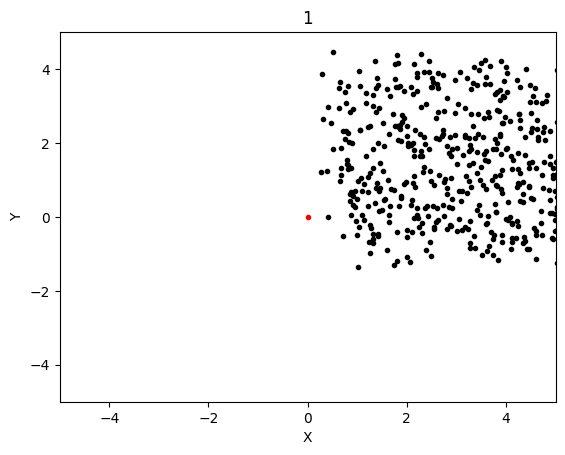

<Figure size 640x480 with 0 Axes>

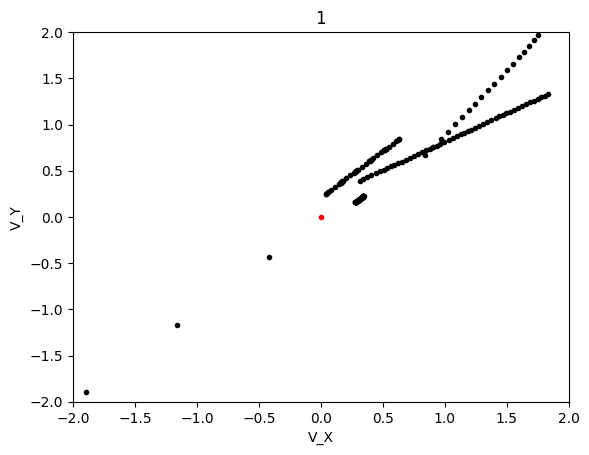

[2] Avg Loss per state: 169.104
[[ 2.9235127   0.44012076  1.355407   -0.11901943]]


<Figure size 640x480 with 0 Axes>

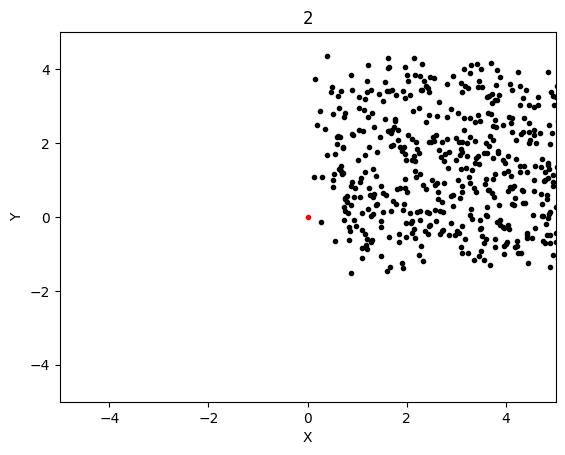

<Figure size 640x480 with 0 Axes>

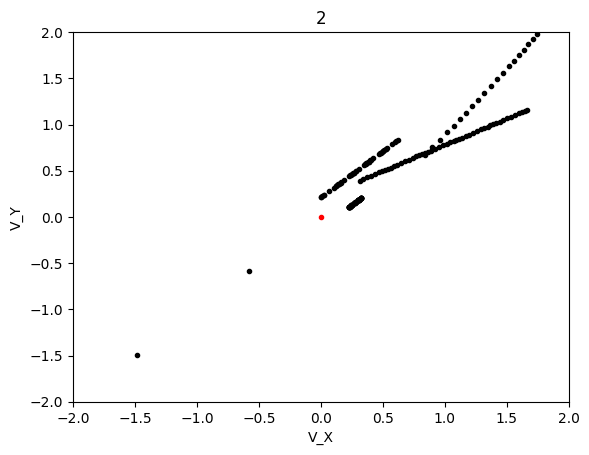

[3] Avg Loss per state: 109.396
[[ 1.93918705 -0.10772054 -1.26538992 -0.7108528 ]]


<Figure size 640x480 with 0 Axes>

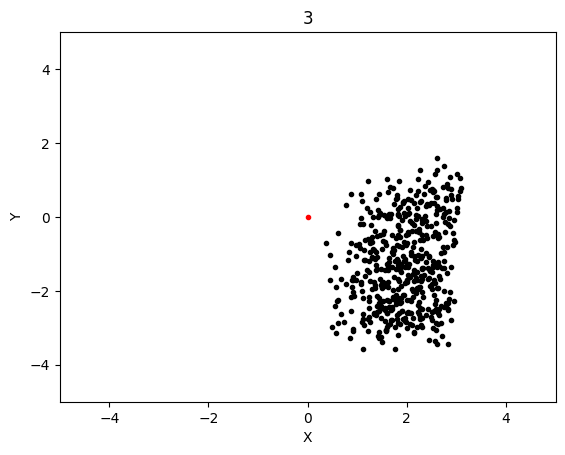

<Figure size 640x480 with 0 Axes>

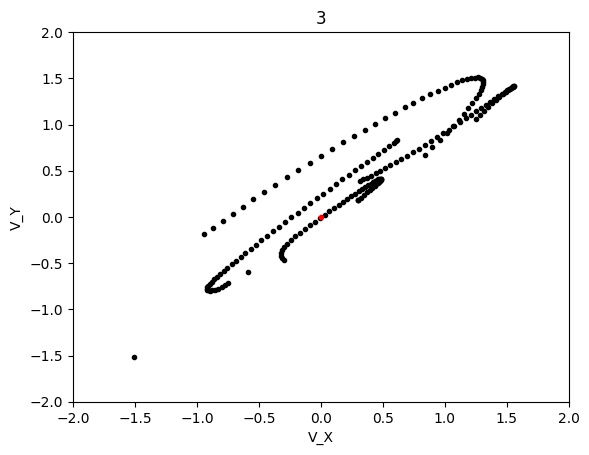

[4] Avg Loss per state: 42.097
[[ 0.88290697 -0.25846833 -0.30013648 -0.32819268]]


<Figure size 640x480 with 0 Axes>

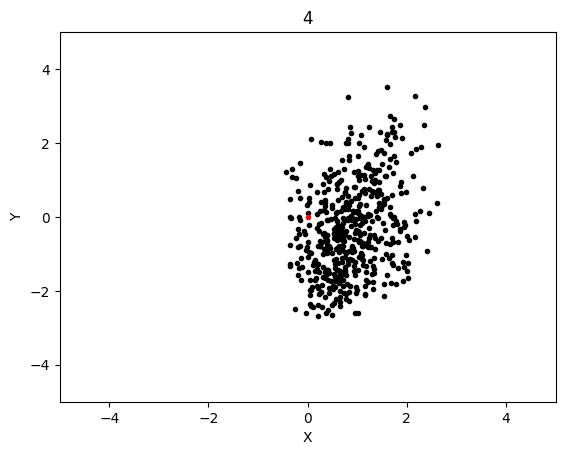

<Figure size 640x480 with 0 Axes>

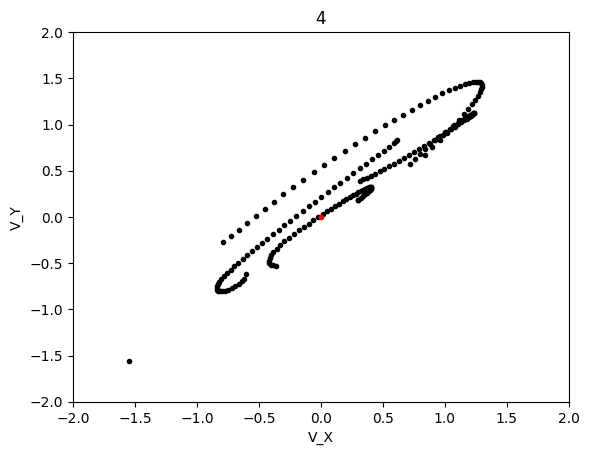

[5] Avg Loss per state: 34.597
[[ 0.73559934 -0.26137885 -0.02628091 -0.21326172]]


<Figure size 640x480 with 0 Axes>

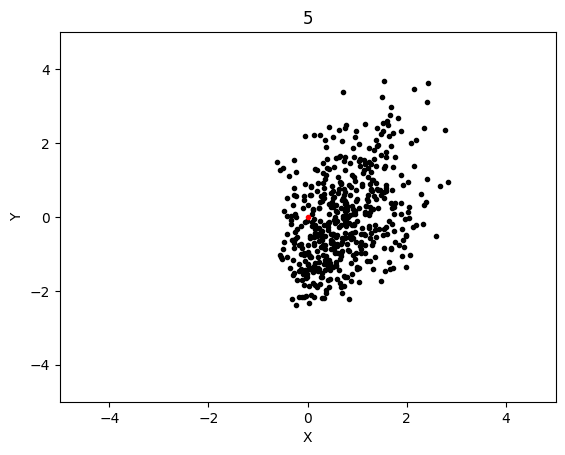

<Figure size 640x480 with 0 Axes>

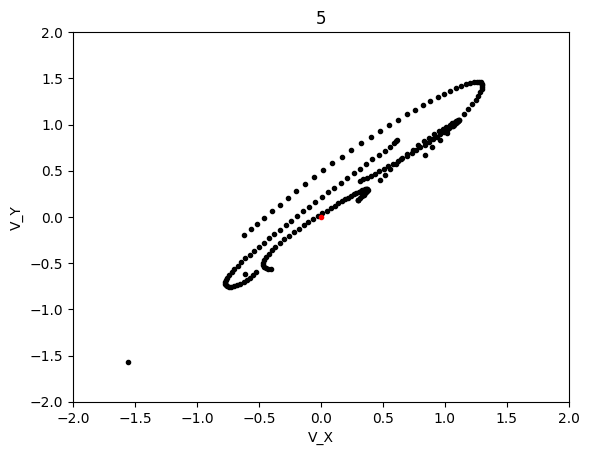

[6] Avg Loss per state: 30.245
[[ 0.63093144 -0.28015697  0.14666088 -0.13287018]]


<Figure size 640x480 with 0 Axes>

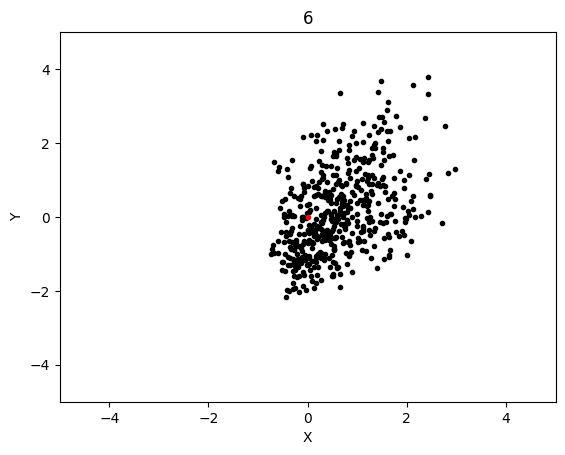

<Figure size 640x480 with 0 Axes>

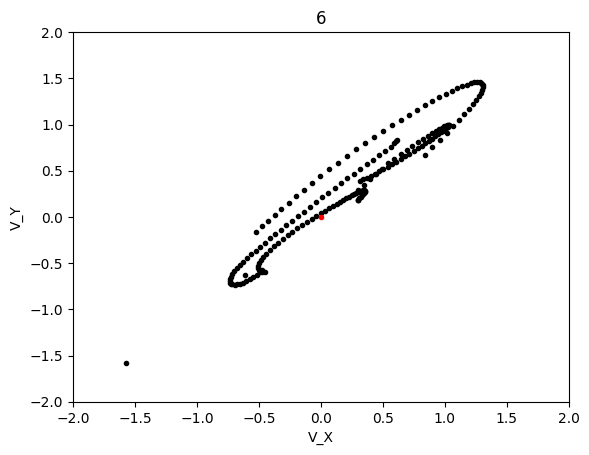

[7] Avg Loss per state: 25.210
[[ 0.50866079 -0.32559329  0.29508439 -0.06487544]]


<Figure size 640x480 with 0 Axes>

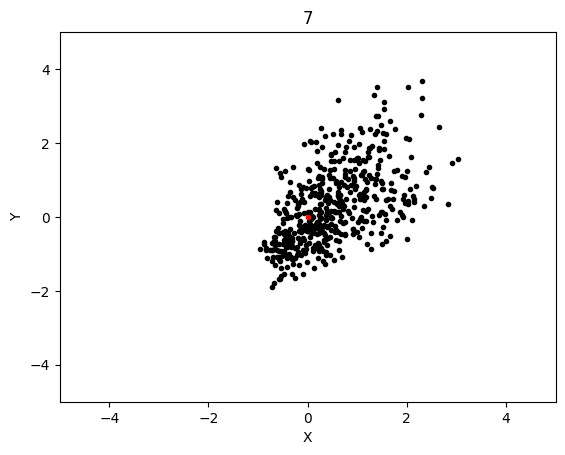

<Figure size 640x480 with 0 Axes>

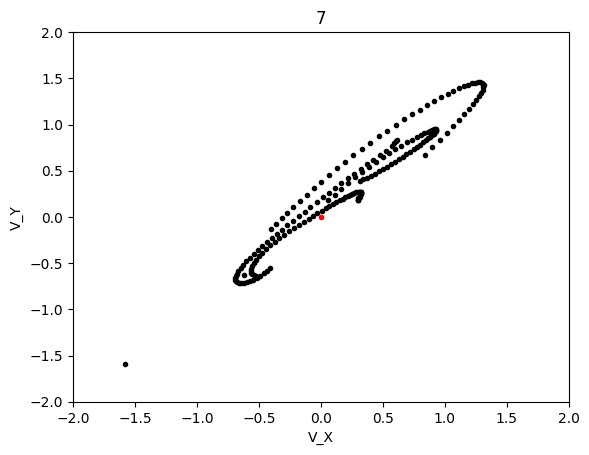

[8] Avg Loss per state: 20.472
[[ 0.409275   -0.36131036  0.40328926 -0.03267957]]


<Figure size 640x480 with 0 Axes>

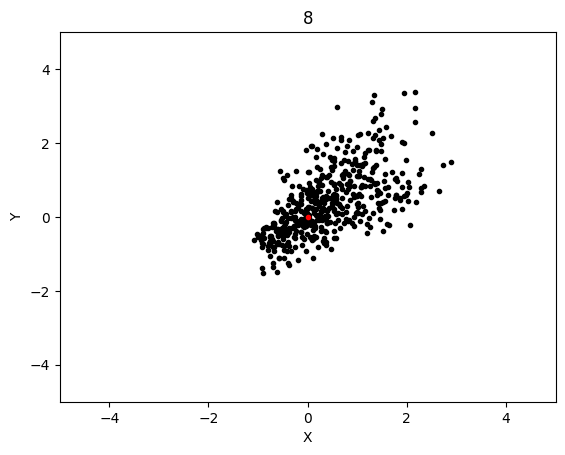

<Figure size 640x480 with 0 Axes>

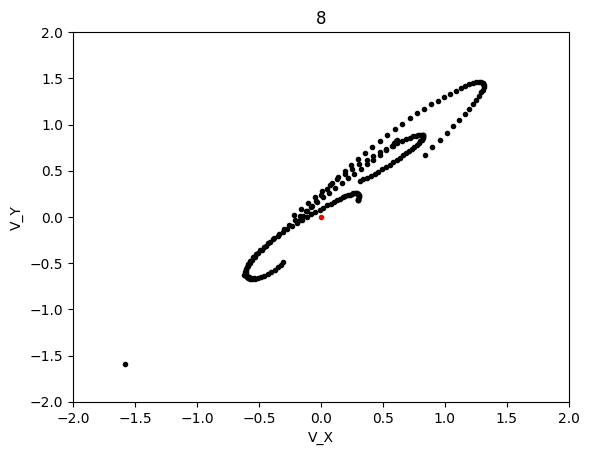

[9] Avg Loss per state: 15.660
[[ 0.33566639 -0.38230842  0.5039053  -0.01306386]]


<Figure size 640x480 with 0 Axes>

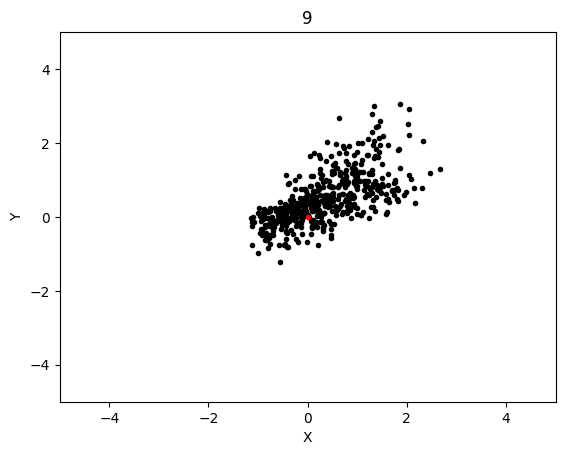

<Figure size 640x480 with 0 Axes>

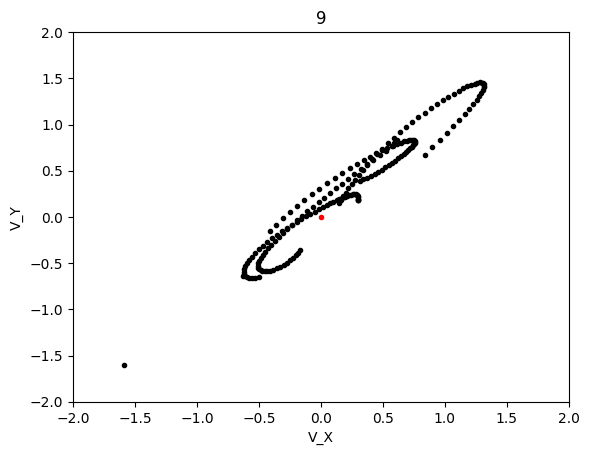

[10] Avg Loss per state: 10.763
[[ 0.31893089 -0.3728601   0.61109209 -0.0085588 ]]


<Figure size 640x480 with 0 Axes>

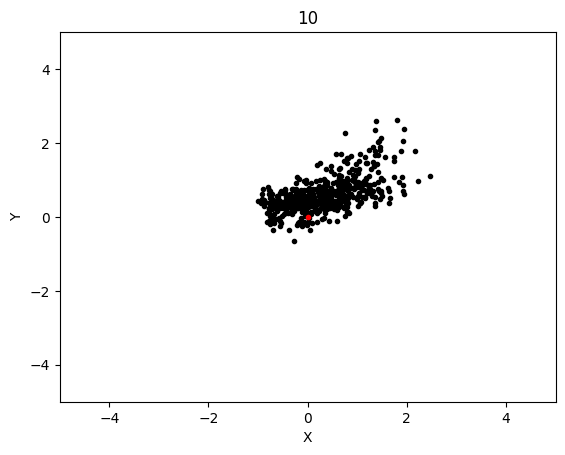

<Figure size 640x480 with 0 Axes>

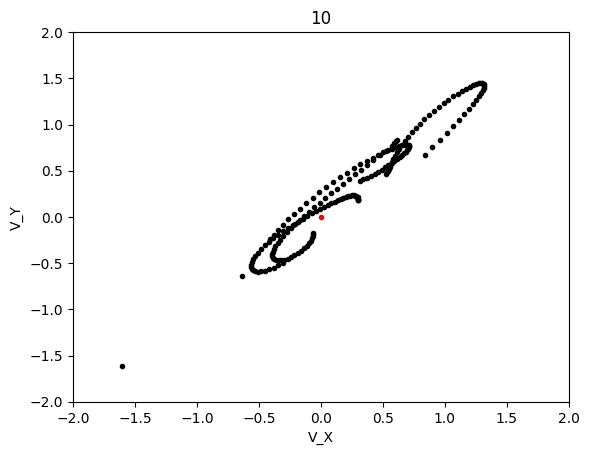

[11] Avg Loss per state: 9.350
[[ 0.32899708 -0.36445051  0.62816346 -0.01642323]]


<Figure size 640x480 with 0 Axes>

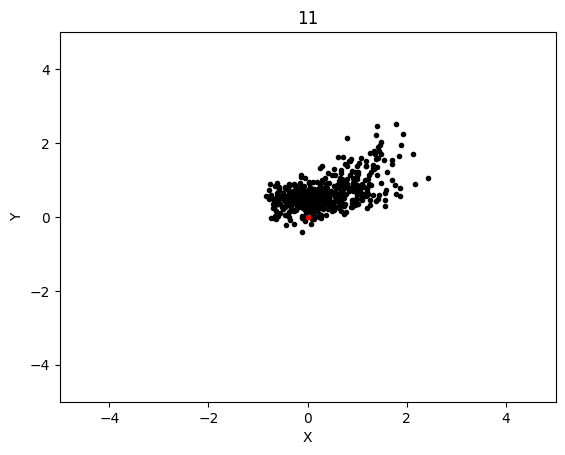

<Figure size 640x480 with 0 Axes>

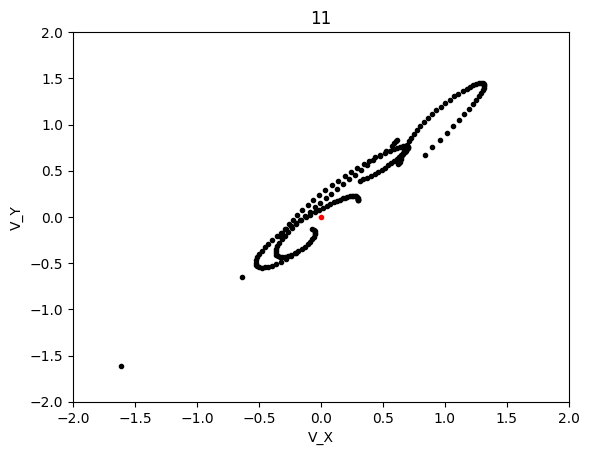

[12] Avg Loss per state: 8.433
[[ 0.33172539 -0.3572495   0.63621235 -0.02171495]]


<Figure size 640x480 with 0 Axes>

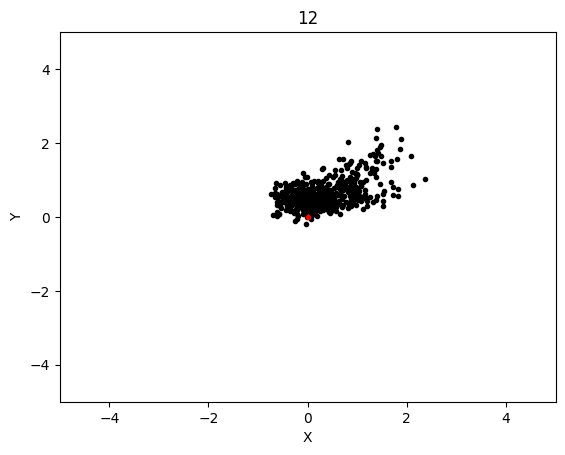

<Figure size 640x480 with 0 Axes>

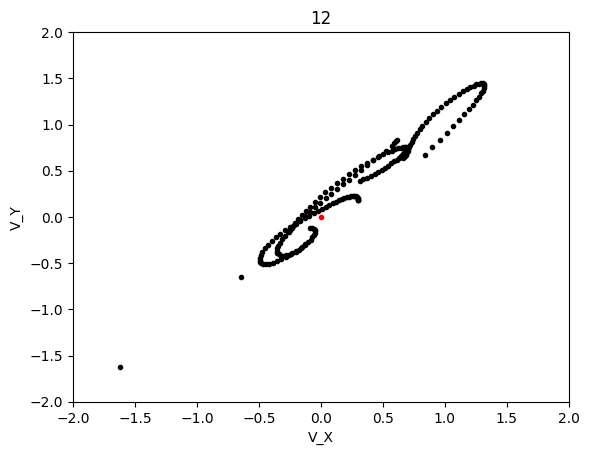

[13] Avg Loss per state: 7.719
[[ 0.32675785 -0.34835911  0.64301652 -0.02649399]]


<Figure size 640x480 with 0 Axes>

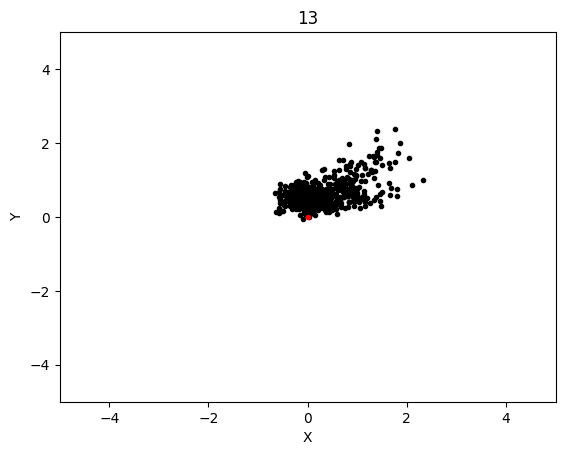

<Figure size 640x480 with 0 Axes>

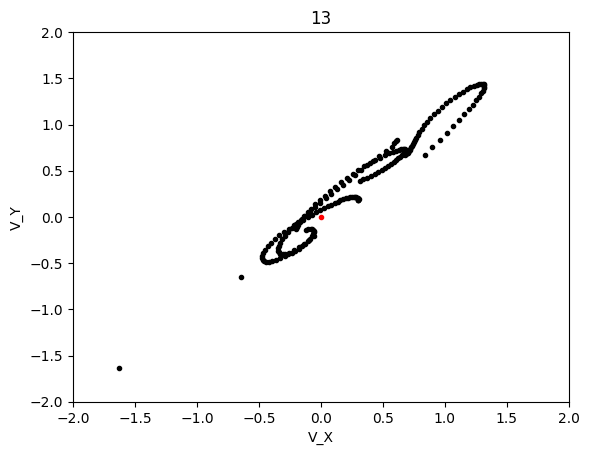

[14] Avg Loss per state: 7.160
[[ 0.31842512 -0.33819965  0.6476171  -0.0303039 ]]


<Figure size 640x480 with 0 Axes>

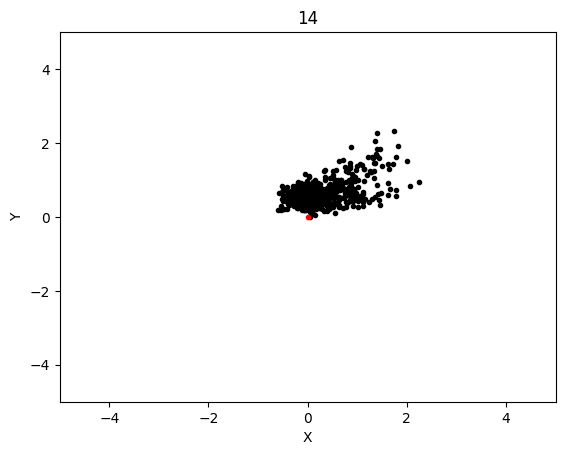

<Figure size 640x480 with 0 Axes>

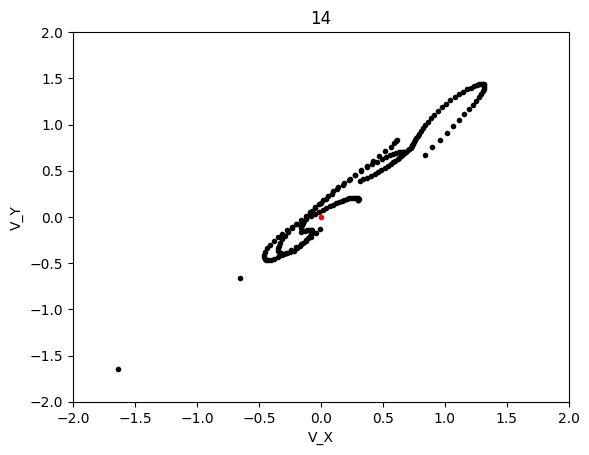

[15] Avg Loss per state: 6.700
[[ 0.31027934 -0.32571754  0.65102845 -0.03172558]]


<Figure size 640x480 with 0 Axes>

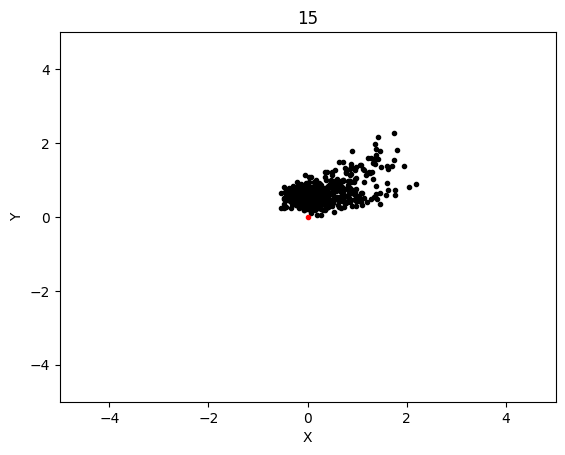

<Figure size 640x480 with 0 Axes>

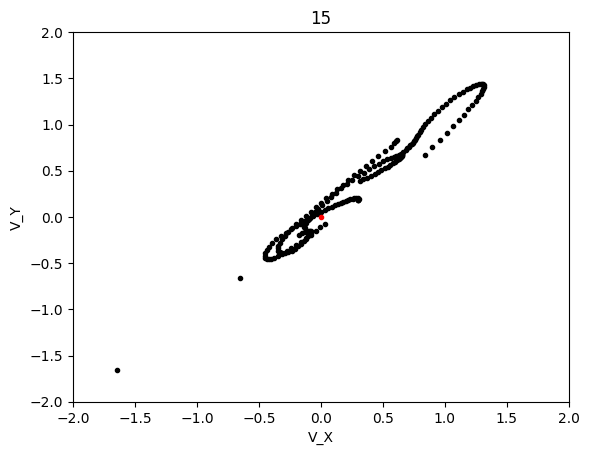

[16] Avg Loss per state: 6.347
[[ 0.30205834 -0.31508386  0.65080434 -0.03265734]]


<Figure size 640x480 with 0 Axes>

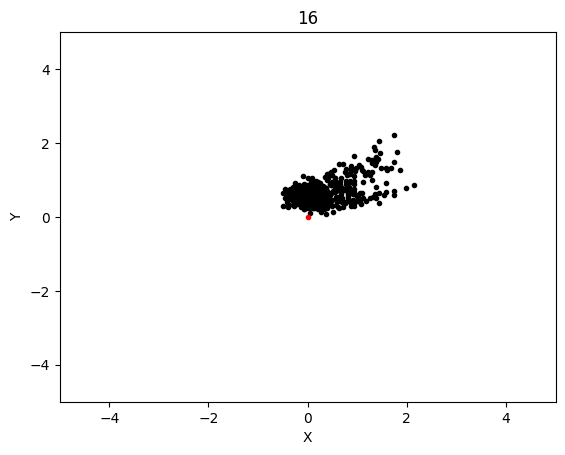

<Figure size 640x480 with 0 Axes>

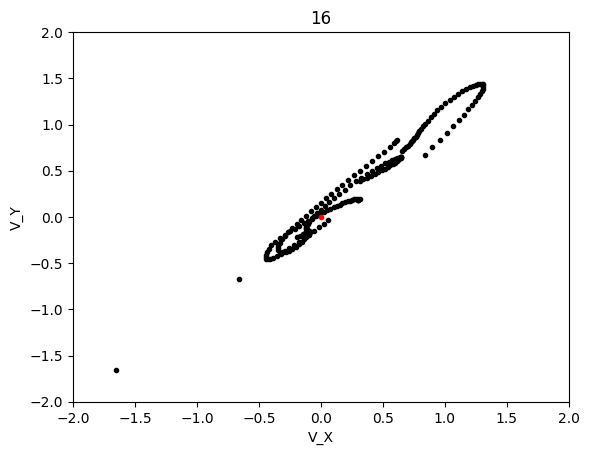

[17] Avg Loss per state: 6.103
[[ 0.29612792 -0.30655944  0.65148062 -0.03139303]]


<Figure size 640x480 with 0 Axes>

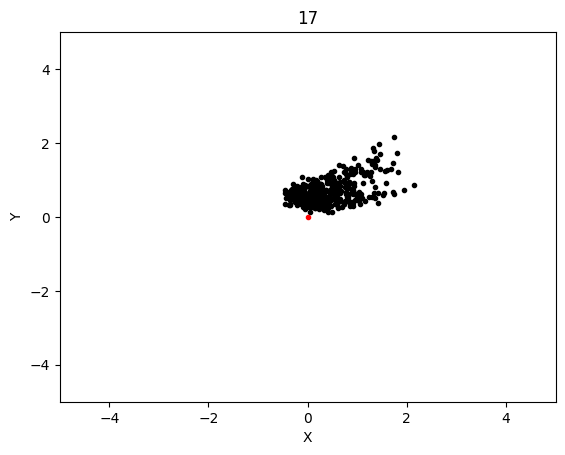

<Figure size 640x480 with 0 Axes>

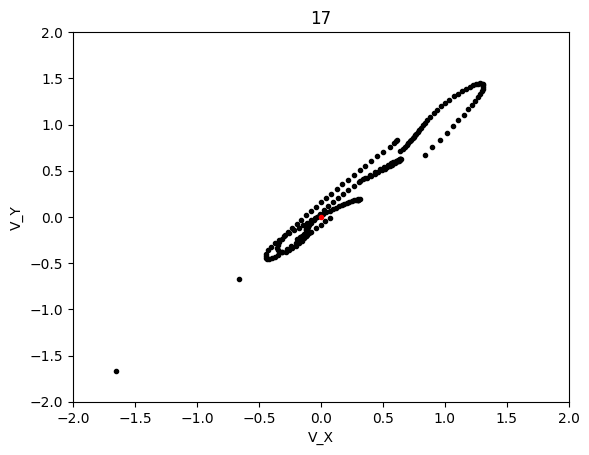

[18] Avg Loss per state: 5.895
[[ 0.29061741 -0.29938671  0.65103686 -0.02906887]]


<Figure size 640x480 with 0 Axes>

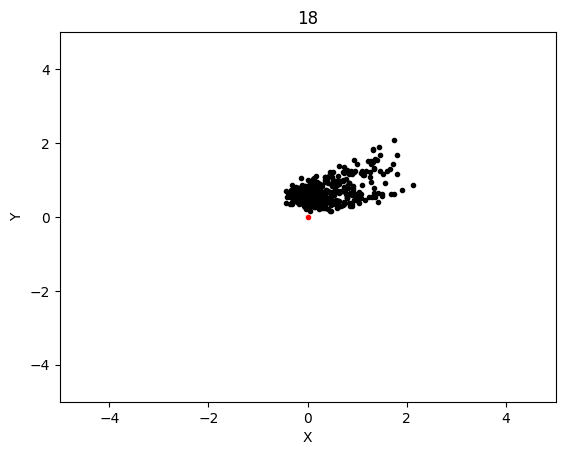

<Figure size 640x480 with 0 Axes>

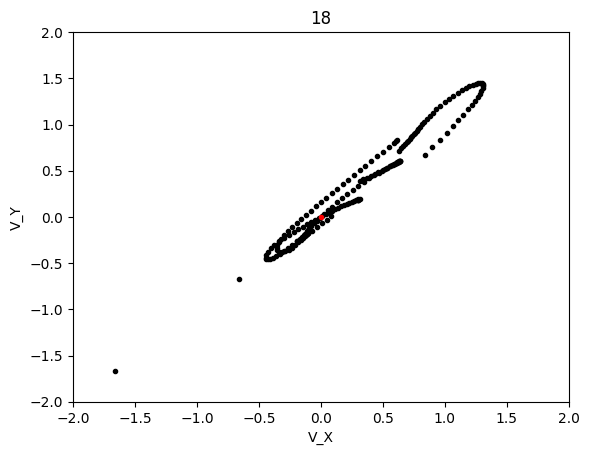

[19] Avg Loss per state: 5.724
[[ 0.28531379 -0.29375288  0.65019876 -0.02721488]]


<Figure size 640x480 with 0 Axes>

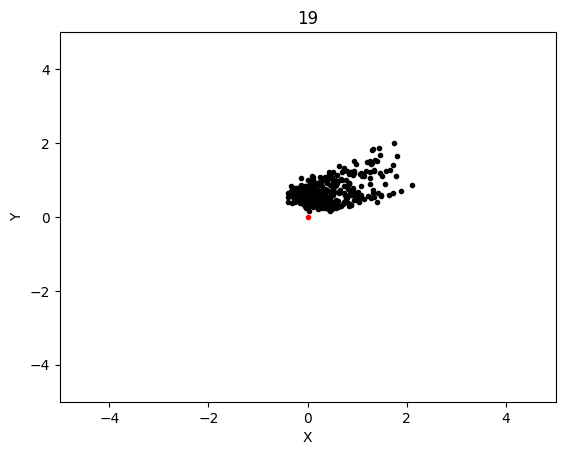

<Figure size 640x480 with 0 Axes>

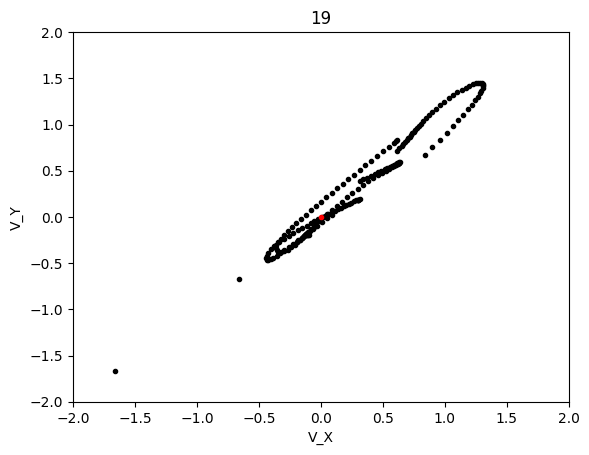

[20] Avg Loss per state: 5.579
[[ 0.2808702  -0.28869954  0.64970362 -0.02560768]]


<Figure size 640x480 with 0 Axes>

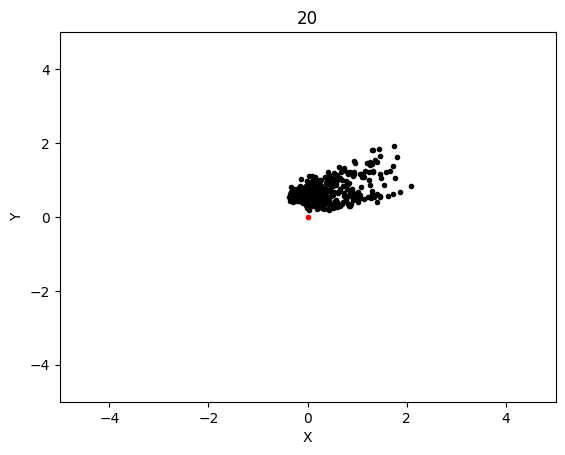

<Figure size 640x480 with 0 Axes>

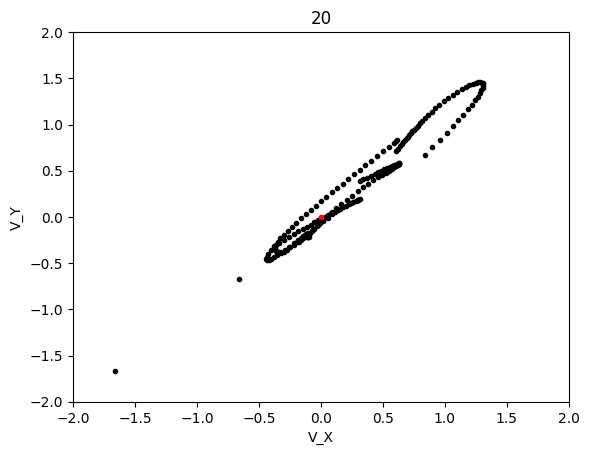

[21] Avg Loss per state: 5.454
[[ 0.27716914 -0.28404599  0.64904338 -0.02465166]]


<Figure size 640x480 with 0 Axes>

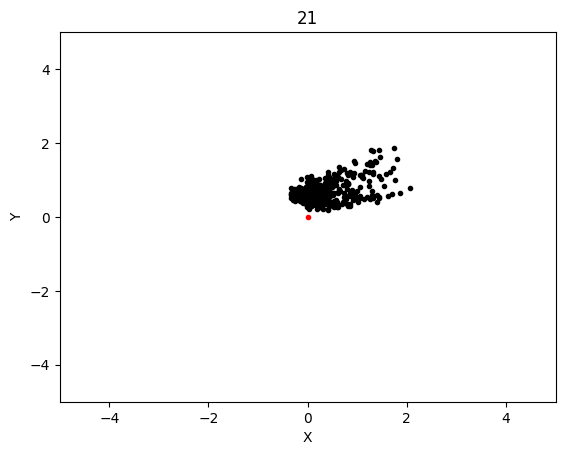

<Figure size 640x480 with 0 Axes>

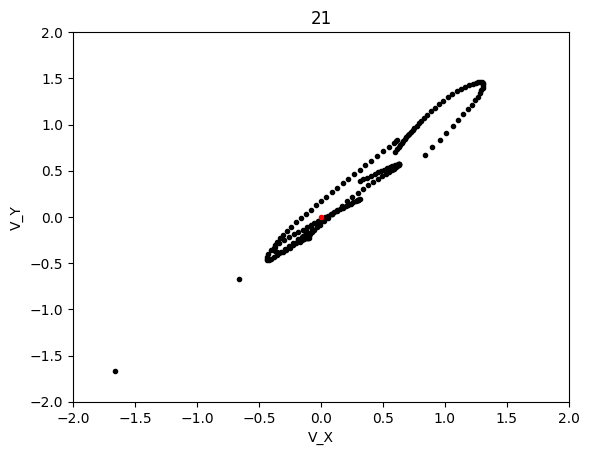

[22] Avg Loss per state: 5.347
[[ 0.2743443  -0.27991095  0.64862156 -0.02394788]]


<Figure size 640x480 with 0 Axes>

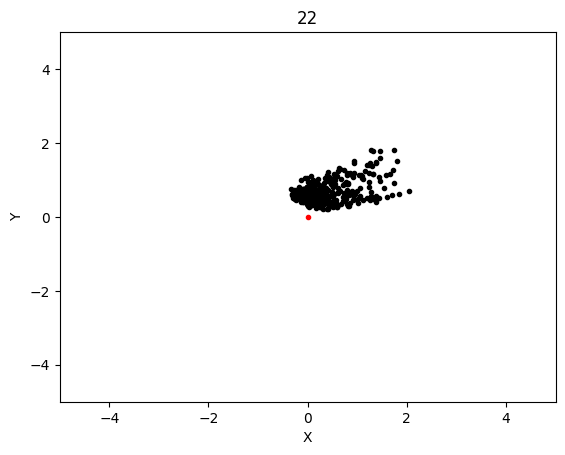

<Figure size 640x480 with 0 Axes>

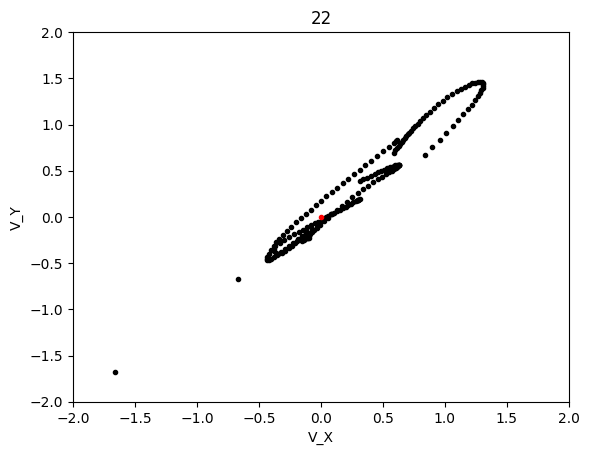

[23] Avg Loss per state: 5.249
[[ 0.27127239 -0.27636877  0.64888257 -0.0238893 ]]


<Figure size 640x480 with 0 Axes>

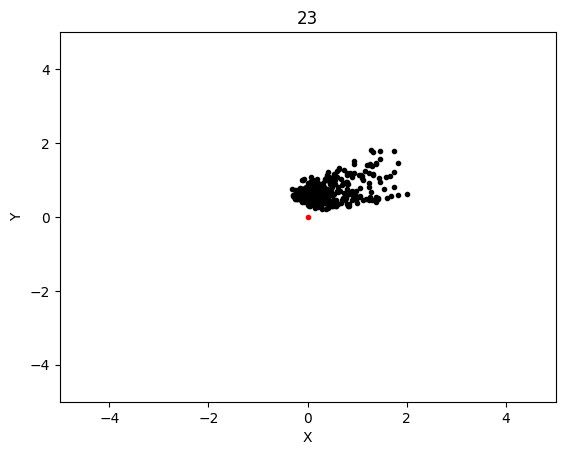

<Figure size 640x480 with 0 Axes>

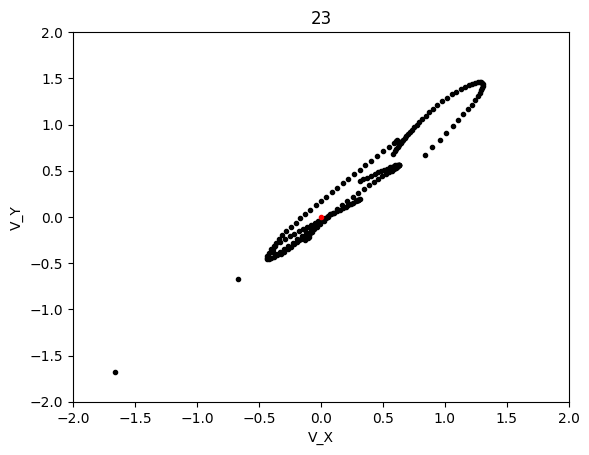

[24] Avg Loss per state: 5.161
[[ 0.26803681 -0.27370444  0.64882529 -0.02536741]]


<Figure size 640x480 with 0 Axes>

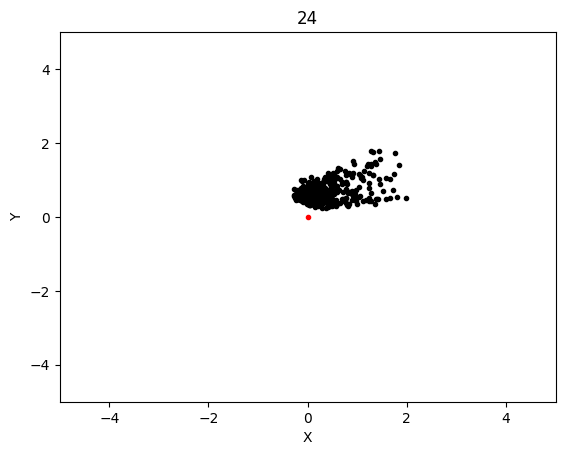

<Figure size 640x480 with 0 Axes>

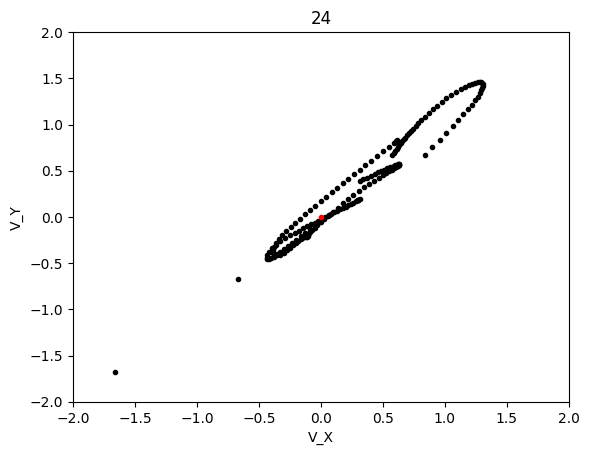

[25] Avg Loss per state: 5.089
[[ 0.26548654 -0.27150247  0.6501708  -0.02770972]]


<Figure size 640x480 with 0 Axes>

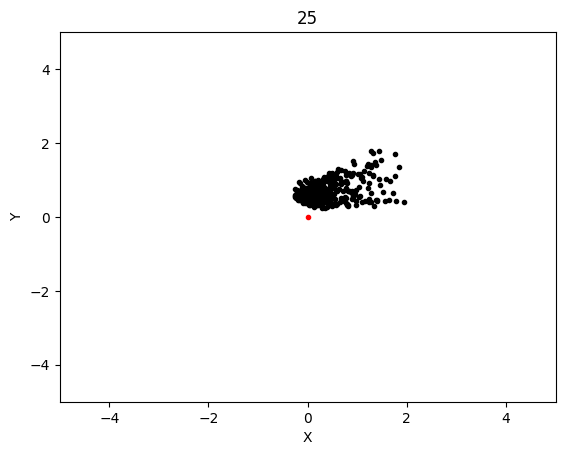

<Figure size 640x480 with 0 Axes>

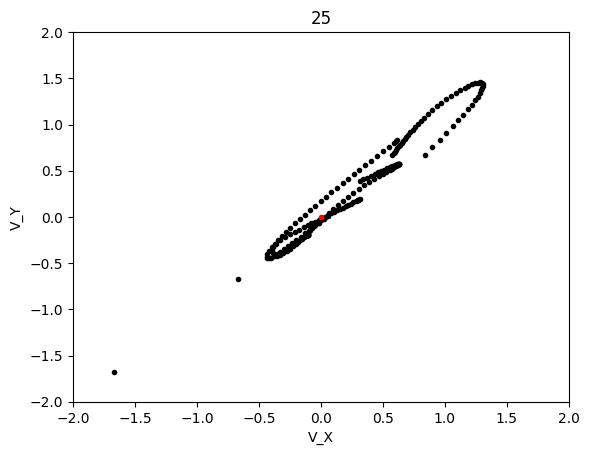

[26] Avg Loss per state: 5.031
[[ 0.26357526 -0.27025738  0.65150255 -0.03070617]]


<Figure size 640x480 with 0 Axes>

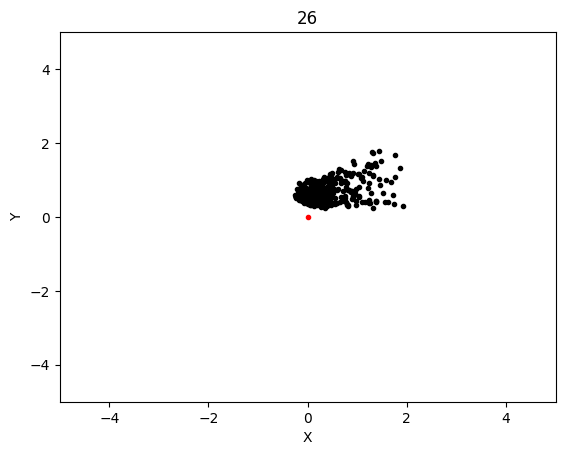

<Figure size 640x480 with 0 Axes>

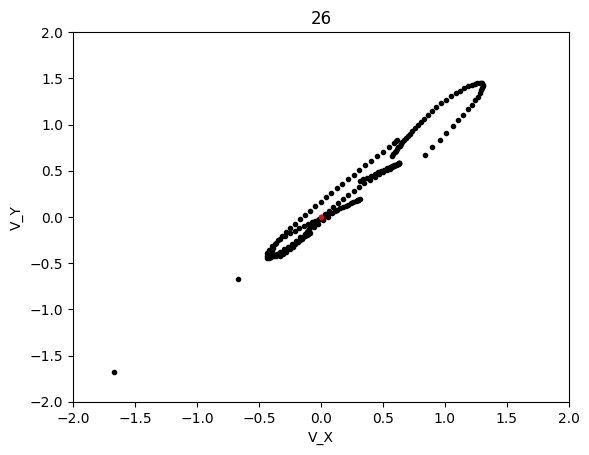

[27] Avg Loss per state: 4.986
[[ 0.26330706 -0.26885766  0.65122706 -0.03424047]]


<Figure size 640x480 with 0 Axes>

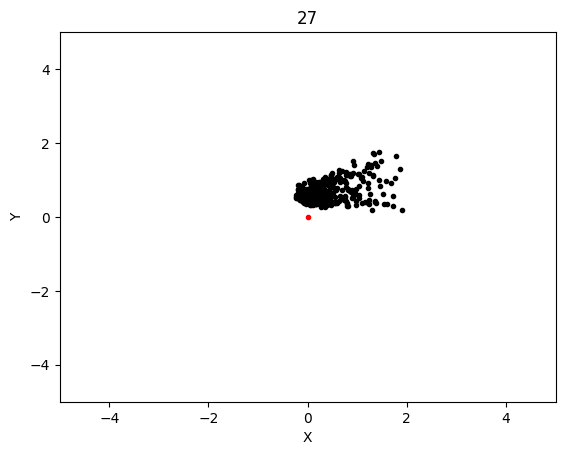

<Figure size 640x480 with 0 Axes>

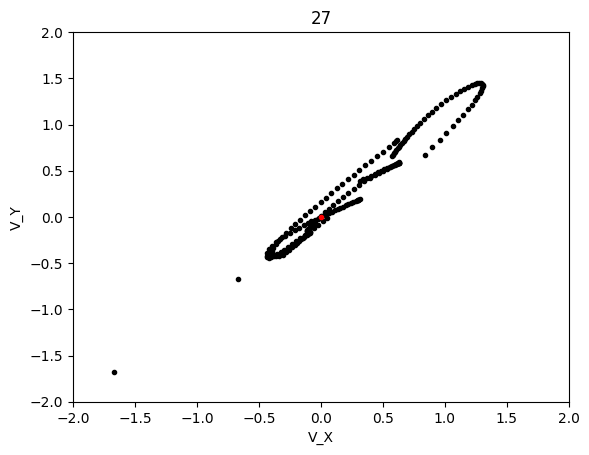

[28] Avg Loss per state: 4.948
[[ 0.26209226 -0.26846784  0.65214586 -0.03676092]]


<Figure size 640x480 with 0 Axes>

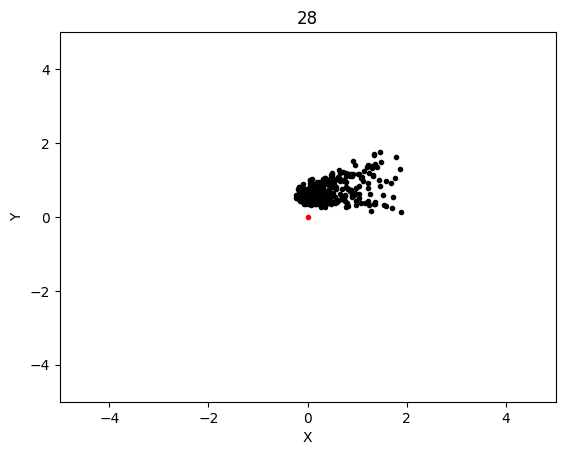

<Figure size 640x480 with 0 Axes>

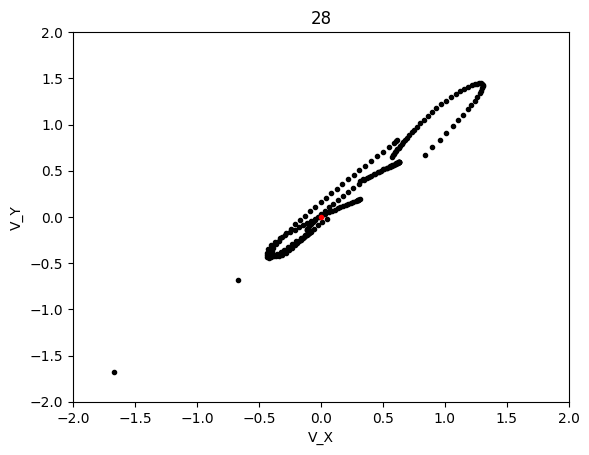

[29] Avg Loss per state: 4.914
[[ 0.26069519 -0.26855427  0.65333694 -0.03828653]]


<Figure size 640x480 with 0 Axes>

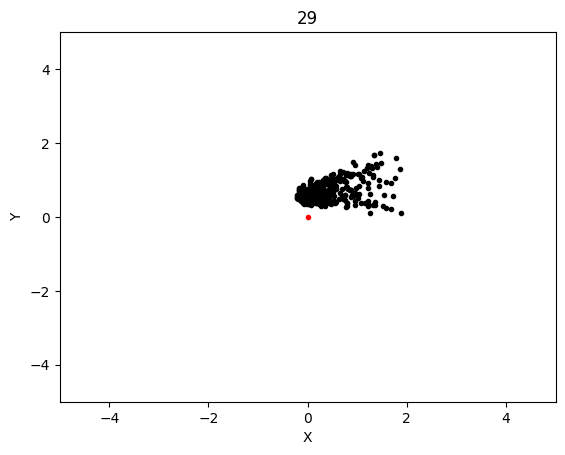

<Figure size 640x480 with 0 Axes>

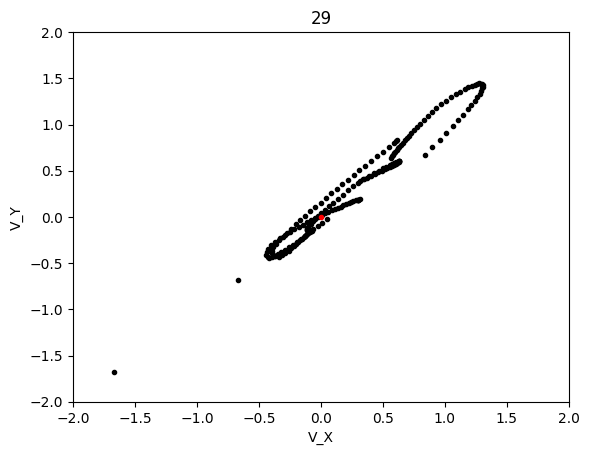

[30] Avg Loss per state: 4.880
[[ 0.25977674 -0.2683118   0.6536538  -0.03941453]]


<Figure size 640x480 with 0 Axes>

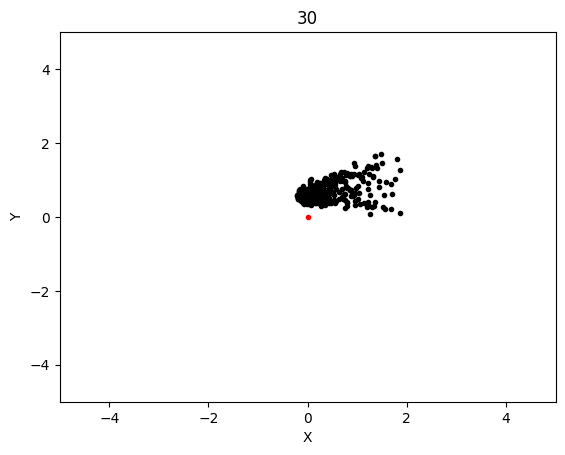

<Figure size 640x480 with 0 Axes>

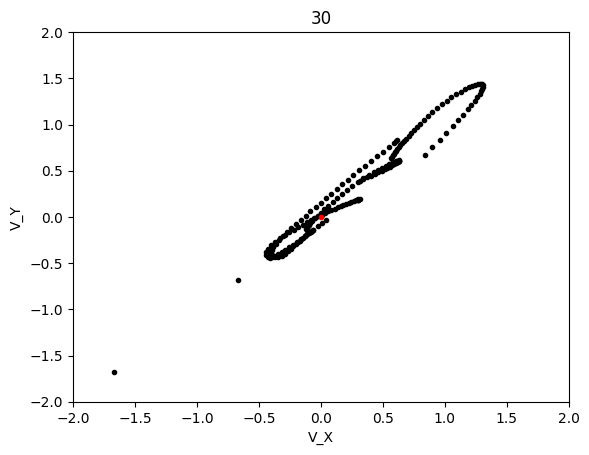

[31] Avg Loss per state: 4.851
[[ 0.2592926  -0.26839006  0.65405101 -0.04003317]]


<Figure size 640x480 with 0 Axes>

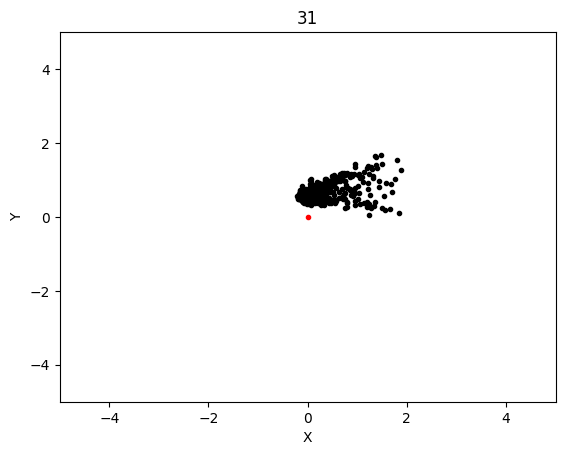

<Figure size 640x480 with 0 Axes>

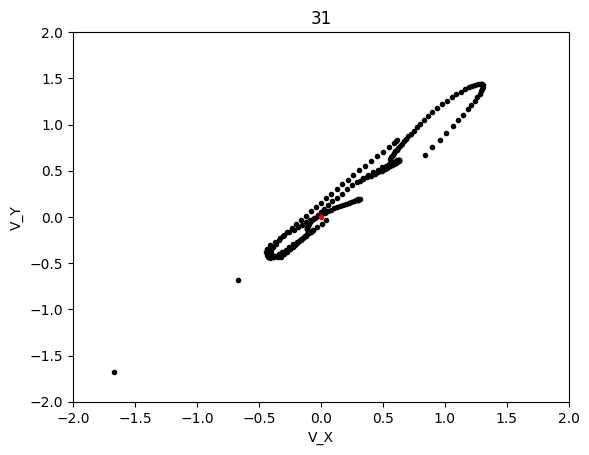

[32] Avg Loss per state: 4.827
[[ 0.25855118 -0.26862317  0.65484828 -0.04038087]]


<Figure size 640x480 with 0 Axes>

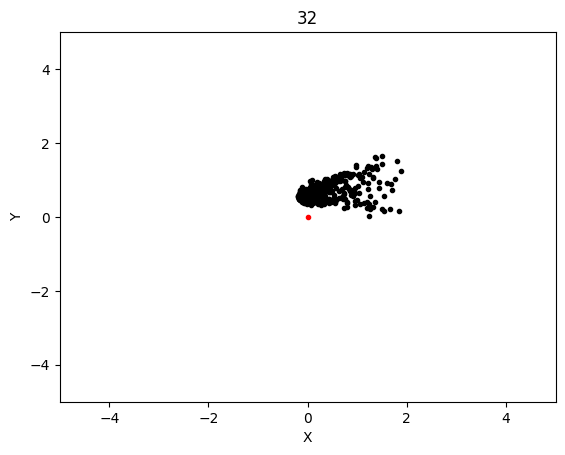

<Figure size 640x480 with 0 Axes>

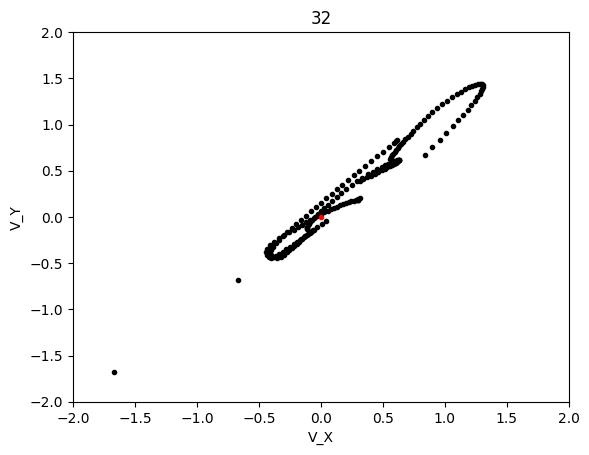

[33] Avg Loss per state: 4.808
[[ 0.258461   -0.26844567  0.65461582 -0.04099498]]


<Figure size 640x480 with 0 Axes>

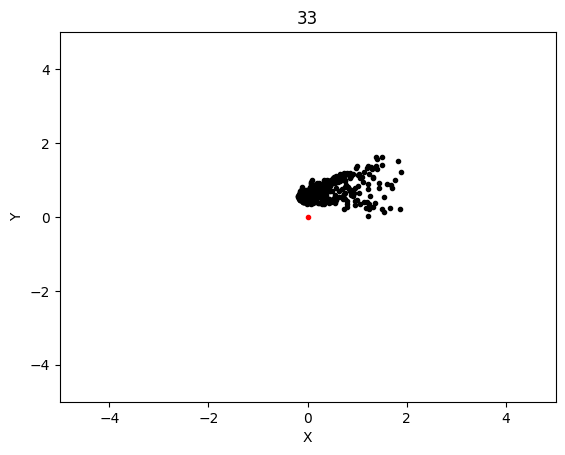

<Figure size 640x480 with 0 Axes>

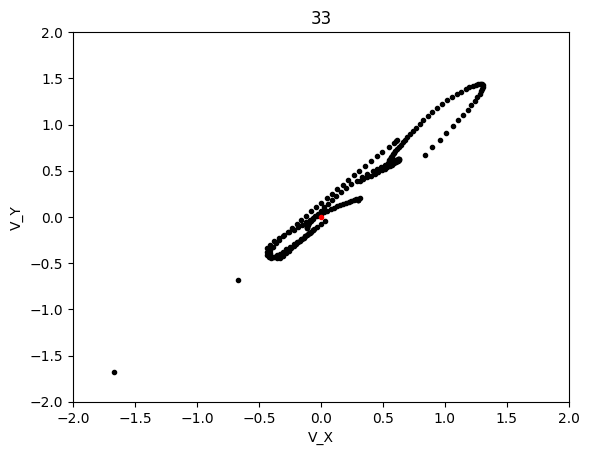

[34] Avg Loss per state: 4.794
[[ 0.25840229 -0.2678532   0.65445888 -0.04203711]]


<Figure size 640x480 with 0 Axes>

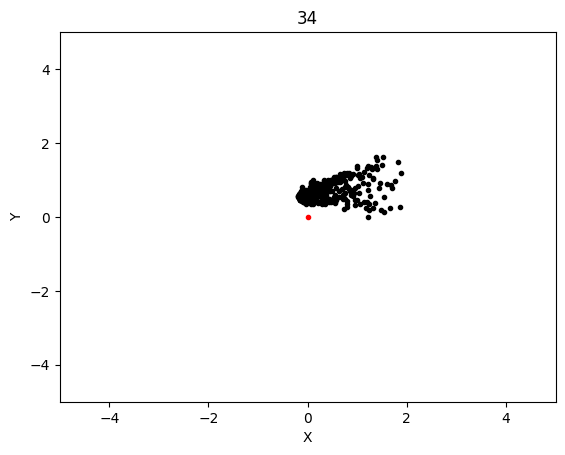

<Figure size 640x480 with 0 Axes>

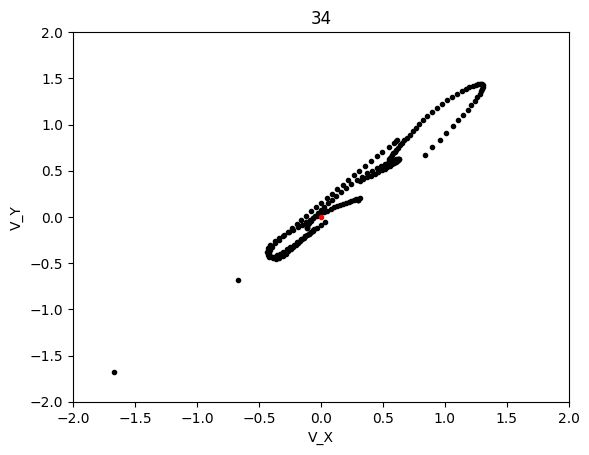

[35] Avg Loss per state: 4.783
[[ 0.25794777 -0.26673004  0.65336257 -0.04377241]]


<Figure size 640x480 with 0 Axes>

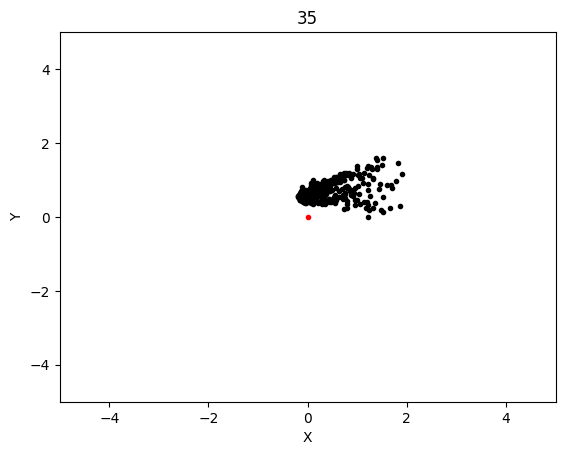

<Figure size 640x480 with 0 Axes>

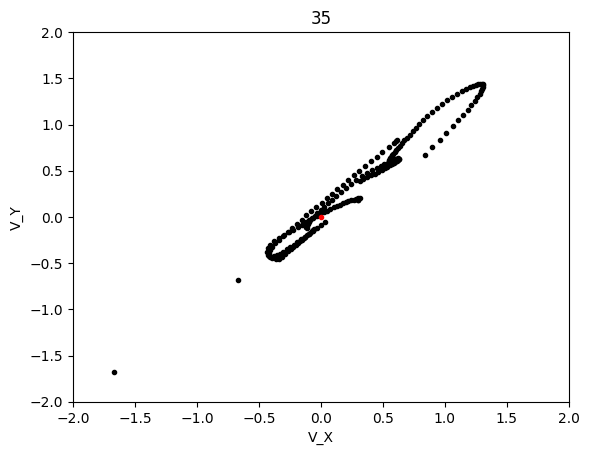

[36] Avg Loss per state: 4.772
[[ 0.25836164 -0.26562604  0.65395528 -0.04454321]]


<Figure size 640x480 with 0 Axes>

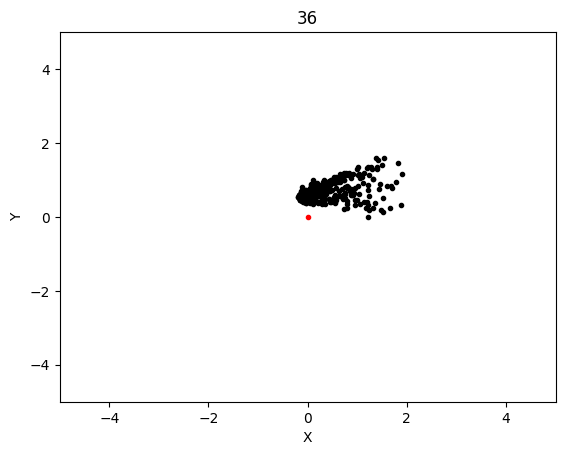

<Figure size 640x480 with 0 Axes>

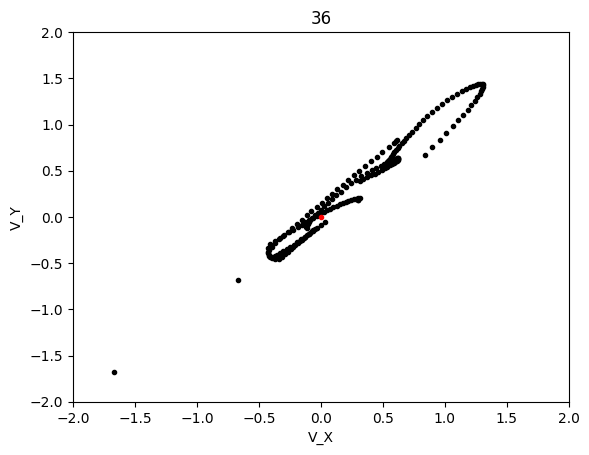

[37] Avg Loss per state: 4.759
[[ 0.25811675 -0.26430637  0.65528113 -0.04616391]]


<Figure size 640x480 with 0 Axes>

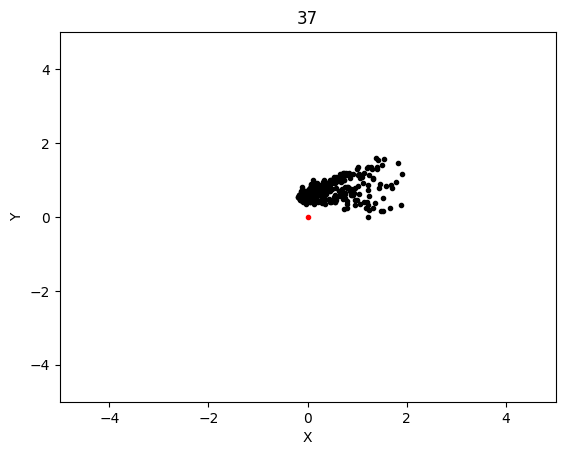

<Figure size 640x480 with 0 Axes>

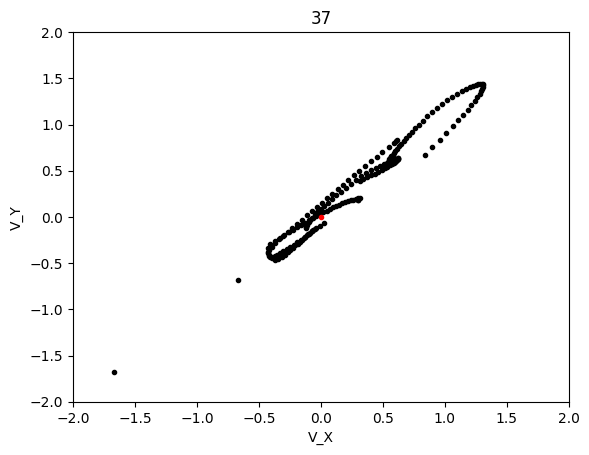

[38] Avg Loss per state: 4.739
[[ 0.25833422 -0.26112103  0.65524721 -0.05020684]]


<Figure size 640x480 with 0 Axes>

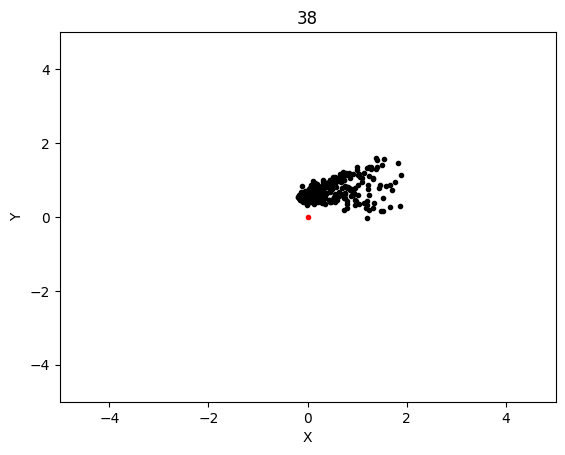

<Figure size 640x480 with 0 Axes>

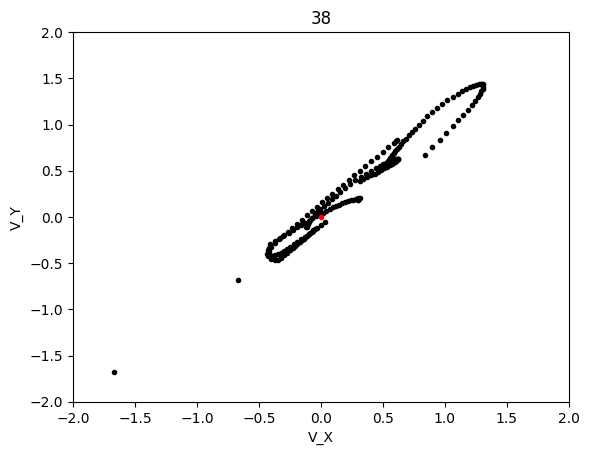

[39] Avg Loss per state: 4.723
[[ 0.25801513 -0.25855789  0.65575051 -0.05462304]]


<Figure size 640x480 with 0 Axes>

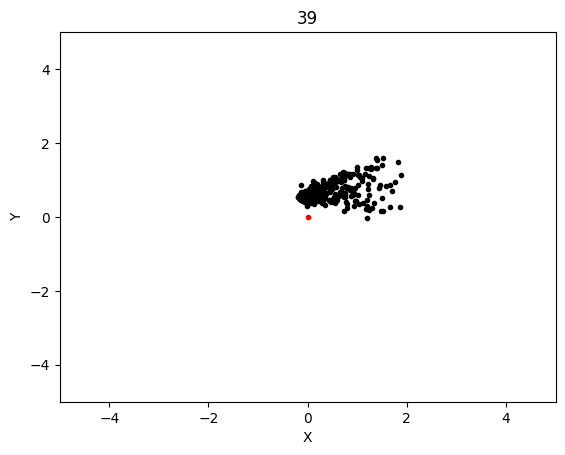

<Figure size 640x480 with 0 Axes>

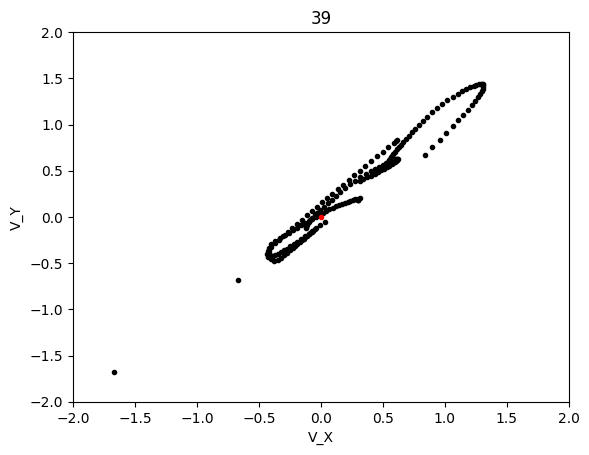

[40] Avg Loss per state: 4.707
[[ 0.25702429 -0.25643694  0.65682632 -0.05931414]]


<Figure size 640x480 with 0 Axes>

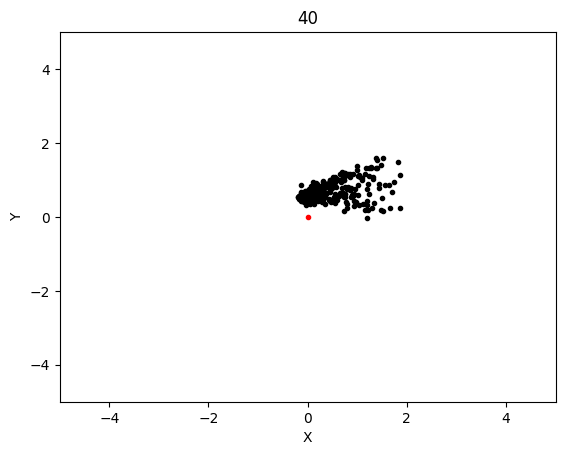

<Figure size 640x480 with 0 Axes>

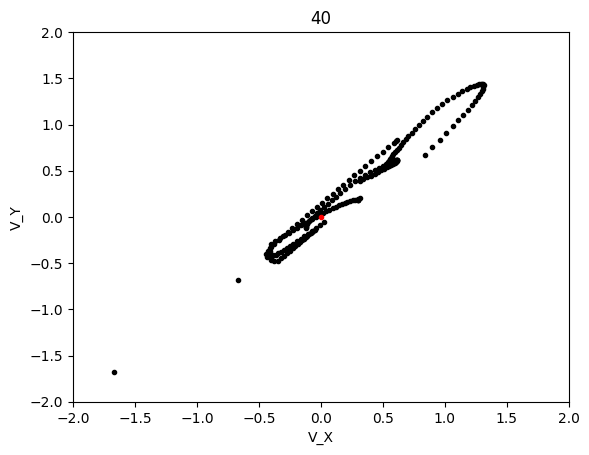

<Figure size 640x480 with 0 Axes>

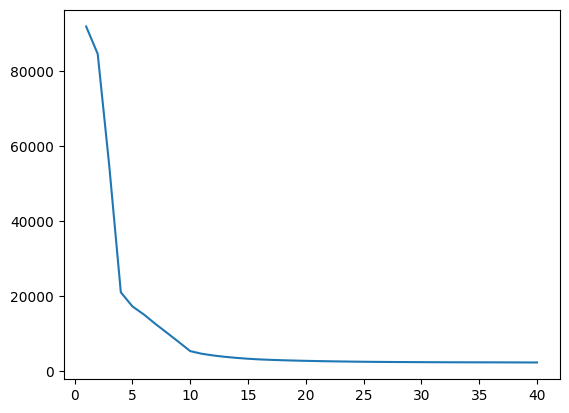

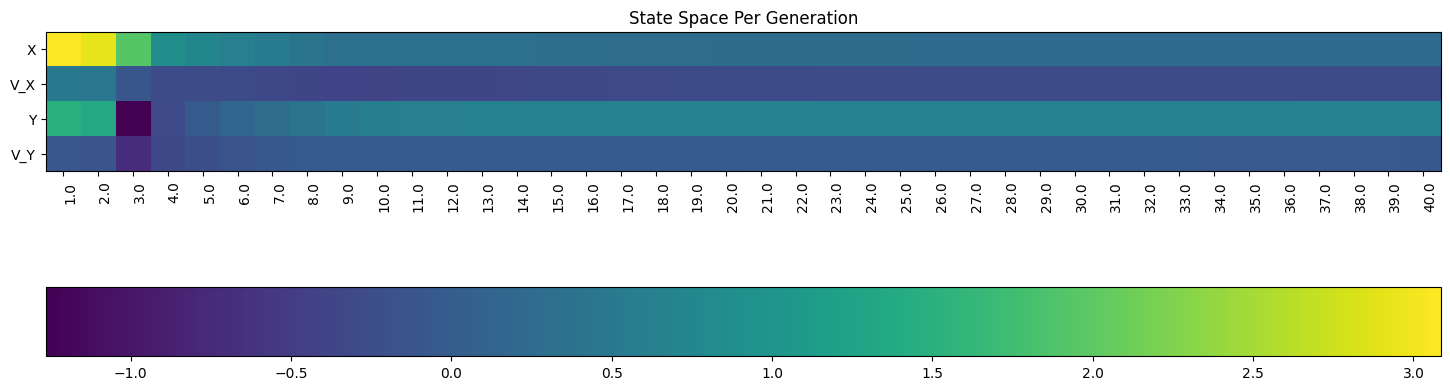

In [30]:
# overhead
import logging
# import math
import random
import numpy as np
# import time
import torch as t
import torch.nn as nn
from torch import optim
# from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.4  # thrust constant

PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.6  # landing platform height
ROTATION_ACCEL = 10  # rotation constant

airDensitySeaLevel = .012250
terminalVel = 1000  # terminal velocity at sea level
C_d = GRAVITY_ACCEL / (airDensitySeaLevel * terminalVel ** 2)

airDensityConstant = -1.186 * 10 ** -6

W = [13, 2., 11., 3.]

numTestStates = 500
numOfEpochs = 40


# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action[0] = thrust controller
        action[1] = omega controller
        state[0] = x
        state[1] = x_dot
        state[2] = y
        state[3] = y_dot
        state[4] = theta
        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed...
        delta_state_gravity = t.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME, 0.])
        # Thrust
        # Note: Same reason as above. Need a 5-by-1 tensor.
        N = len(state)
        state_tensor = t.zeros((N, 5))

        state_tensor[:, 1] = -t.sin(state[:, 4])

        state_tensor[:, 3] = t.cos(state[:, 4])

        delta_state_acc = BOOST_ACCEL * FRAME_TIME * t.mul(state_tensor, action[:, 0].reshape(-1, 1))

        # Theta
        state_tensor_drag = t.zeros((N, 5))
        state_tensor_drag[:, 1] = - C_d * airDensitySeaLevel * t.mul(t.exp(t.mul(state[:, 2], airDensityConstant)),
                                                                     t.mul(state[:, 1], state[:, 1]))

        state_tensor_drag[:, 3] = C_d * airDensitySeaLevel * t.mul(t.exp(t.mul(state[:, 2], airDensityConstant)),
                                                                   t.mul(state[:, 3], state[:, 3]))
        delta_state_drag = FRAME_TIME * state_tensor_drag

        delta_state_theta = FRAME_TIME * ROTATION_ACCEL * t.mul(t.tensor([0., 0., 0., 0, -1.]),
                                                                action[:, 1].reshape(-1, 1))

        state = state + delta_state_acc + delta_state_gravity + delta_state_theta + delta_state_drag
        # Update state
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0.],
                             [0., 1., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0.],
                             [0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 1.]])

        state = t.matmul(step_mat, t.transpose(state, 0, 1))

        return t.transpose(state, 0, 1)


# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_h2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """

        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_h2),
            nn.Tanh(),
            nn.Linear(dim_h2, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        states = t.ones(numTestStates, 5)

        for i in range(0, numTestStates):
            states[i][0] = random.uniform(0, 1)
            states[i][1] = random.uniform(0, 1)
            states[i][2] = random.uniform(0, 1)
            states[i][3] = random.uniform(0, 1)
            states[i][4] = random.uniform(0, 1)
        print(states)
        return t.tensor(states, requires_grad=False).float()

    def error(self, state):
        errorCumulative = sum(
            W[0] * state[:, 0] ** 2 + W[1] * state[:, 1] ** 2 + W[2] * (state[:, 2] - PLATFORM_HEIGHT) ** 2 + W[
                3] * state[:, 3] ** 2)
        # print(errorCumulative)

        return errorCumulative


# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    # try adam
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs, T):
        lossArray = np.zeros(numOfEpochs)
        combAvgSS = np.empty((0, 4), float)
        for epoch in range(epochs):
            loss = self.step()
            lossArray[epoch] = loss
            print('[%d] Avg Loss per state: %.3f' % (epoch + 1, loss / numTestStates))
            StateSpace = np.array([self.simulation.state_trajectory[T - 1].detach().numpy()])

            avgSS = np.zeros([1, 4])
            avgSS[0, 0] = np.mean(StateSpace[:, :, 0])
            avgSS[0, 1] = np.mean(StateSpace[:, :, 1])
            avgSS[0, 2] = np.mean(StateSpace[:, :, 2])
            avgSS[0, 3] = np.mean(StateSpace[:, :, 3])

            print(avgSS)

            combAvgSS = np.append(combAvgSS, avgSS, axis=0)
            plt.figure(1)
            self.visualize(T, epoch)
        epochNum = np.linspace(1, epochs, epochs)
        plt.figure(2)
        plt.plot(epochNum, lossArray)
        plt.show()

        stateNames = ["X", "V_X", "Y", "V_Y"]
        fig, ax = plt.subplots(figsize=(18, 10))
        im = ax.imshow(combAvgSS.T)

        cbar = ax.figure.colorbar(im, ax=ax, cmap="YlGn", orientation="horizontal")

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(len(epochNum)), labels=epochNum)
        ax.set_yticks(np.arange(len(stateNames)), labels=stateNames)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

        # for i in range(len(stateNames)):
        #     for j in range(len(epochNum)):
        #         text = ax.text(j,i, combAvgSS.T[i, j], ha="center", va="center", color="w", fontsize="x-small")

        ax.set_title("State Space Per Generation")
        plt.show()

    def visualize(self, T, Epoch):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])

        x = data[T - 1, :, 0]
        vx = data[:, 1]
        y = data[T - 1, :, 2]
        vy = data[:, 3]

        plt.figure(3)
        plt.plot(x, y, 'k.')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(Epoch + 1)
        plt.plot((0), 'r.')
        plt.xlim([-5, 5])
        plt.ylim([-5, 5])
        plt.show()
        plt.clf()

        plt.figure(4)
        plt.plot(vx, vy, 'k.')
        plt.xlabel('V_X')
        plt.ylabel('V_Y')
        plt.title(Epoch + 1)
        plt.plot((0), 'r.')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.show()
        plt.clf()


# Now it's time to run the code!

T = 50  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 8  # latent dimensions
dim_h2 = 5
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_h2, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(numOfEpochs, T)  # solve the optimization problem
